### Importing Libraries & Reading Data

In [56]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [35]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
# load dataset
fraud_df2 = pd.read_csv('data/creditcard_2023.csv')
fraud_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

### Data Preprocessing and Model Architecture

In [ ]:
# remove unnecessary columns (id has no predictive value)
fraud_df2.drop(['id'], axis=1, inplace=True)

In [38]:
# prepare features and target
X = fraud_df2.drop('Class', axis=1)
y = fraud_df2['Class']

In [39]:
# split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

70-15-15 split with stratification to maintain class balance


In [40]:
# scale features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

StandardScaler ensures `Amount` feature is on same scale as `V` features

In [57]:
joblib.dump(scaler, 'models/european_scaler.pkl')

['models/european_scaler.pkl']

In [41]:
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (398041, 29)
Validation set: (85294, 29)
Test set: (85295, 29)


In [42]:
# build model
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dropout(0.2),
        
        Dense(8, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [43]:
model = create_model(X_train_scaled.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               7680      
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 128)              

- Deep network (6 hidden layers) can capture complex non-linear patterns in PCA features

- Decreasing layer sizes (256→128→64→32→16→8) create a funnel that progressively abstracts 
features

- BatchNormalization stabilizes training and allows higher learning rates

- Dropout layers prevent overfitting on this complex dataset

- Sigmoid output provides probability scores for binary classification

### Model Training

In [44]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

- EarlyStopping prevents overfitting by monitoring validation loss

- ReduceLROnPlateau adaptively reduces learning rate when loss plateaus

In [ ]:
# train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=512, # for stable gradient updates on large dataset
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
778/778 [==============================] - 17s 20ms/step - loss: 3.5346 - accuracy: 0.9069 - val_loss: 0.1951 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 2/100
778/778 [==============================] - 14s 18ms/step - loss: 0.3092 - accuracy: 0.9304 - val_loss: 0.1315 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 3/100
778/778 [==============================] - 14s 17ms/step - loss: 0.1906 - accuracy: 0.9404 - val_loss: 0.1134 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 4/100
778/778 [==============================] - 14s 18ms/step - loss: 0.1700 - accuracy: 0.9438 - val_loss: 0.1270 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 5/100
778/778 [==============================] - 13s 17ms/step - loss: 0.1768 - accuracy: 0.9427 - val_loss: 0.1183 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 6/100
778/778 [==============================] - 13s 17ms/step - loss: 0.1675 - accuracy: 0.9446 - val_loss: 0.1198 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 7/100
778/778 [==============================]

### Model Evaluation

In [46]:
# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
test_preds = model.predict(X_test_scaled)
test_preds_binary = (test_preds > 0.5).astype(int)

2666/2666 [==============================] - 7s 3ms/step


In [ ]:
# get metrics
test_precision = precision_score(y_test, test_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)
test_f1 = f1_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds)
test_ap = average_precision_score(y_test, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Test Average Precision: {test_ap:.4f}")

Test Accuracy: 0.9568
Test Precision: 0.9756
Test Recall: 0.9371
Test F1-Score: 0.9559
Test AUC-ROC: 0.9908
Test Average Precision: 0.9922


Metric Interpretation 

- Accuracy (95.68%): Overall correctness - high due to balanced dataset

- Precision (97.56%): Of predicted frauds, 97.56% are actually fraud - excellent for minimizing false alarms

- Recall (93.71%): Catches 93.71% of actual frauds - good fraud detection rate

- F1-Score (95.59%): Balanced harmonic mean of precision and recall

- AUC-ROC (99.08%): Excellent discrimination between classes across all thresholds

- Average Precision (99.22%): Outstanding performance on precision-recall trade-off

In [48]:
# classification report
print(classification_report(y_test, test_preds_binary))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     42648
           1       0.98      0.94      0.96     42647

    accuracy                           0.96     85295
   macro avg       0.96      0.96      0.96     85295
weighted avg       0.96      0.96      0.96     85295



- Class 0 (Legitimate): 94% precision, 98% recall - slightly more false positives than false negatives

- Class 1 (Fraud): 98% precision, 94% recall - excellent fraud identification with minimal false alarms

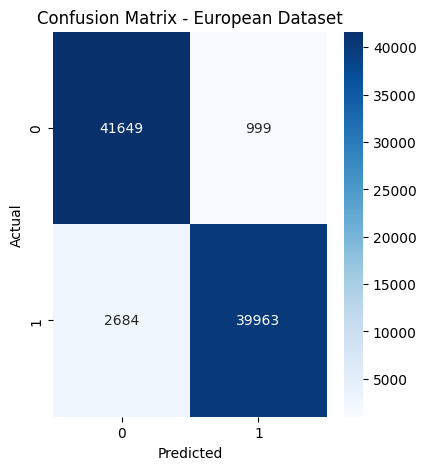

In [53]:
# confusion Matrix 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, test_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - European Dataset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- True Negatives (41,649): Correctly identified legitimate transactions

- False Positives (999): Legitimate transactions incorrectly flagged as fraud

- False Negatives (2,684): Missed fraud cases - most concerning for business

- True Positives (39,963): Correctly caught fraud cases

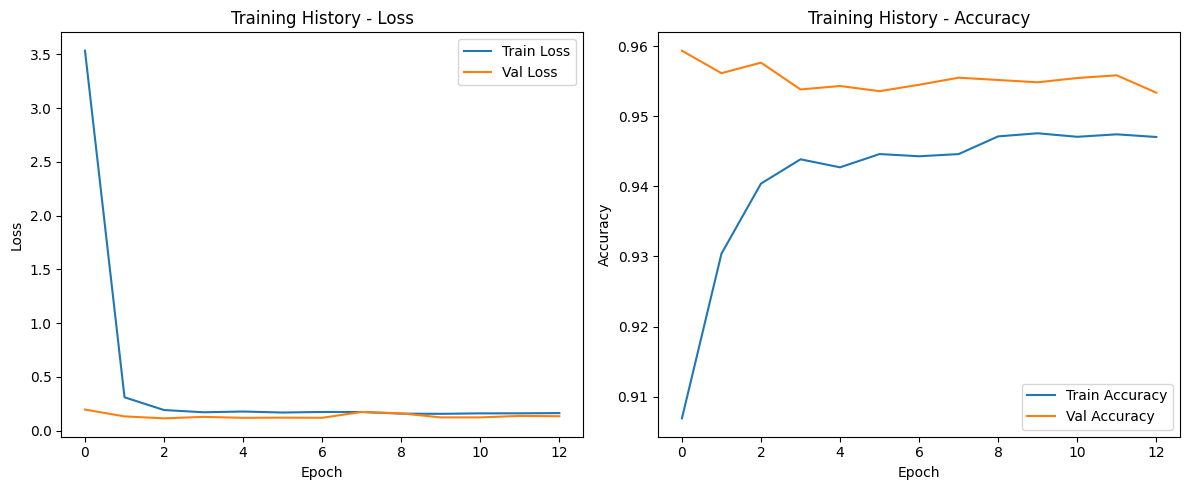

In [50]:
# training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Stable Training: Callbacks prevented overfitting and optimized learning rate

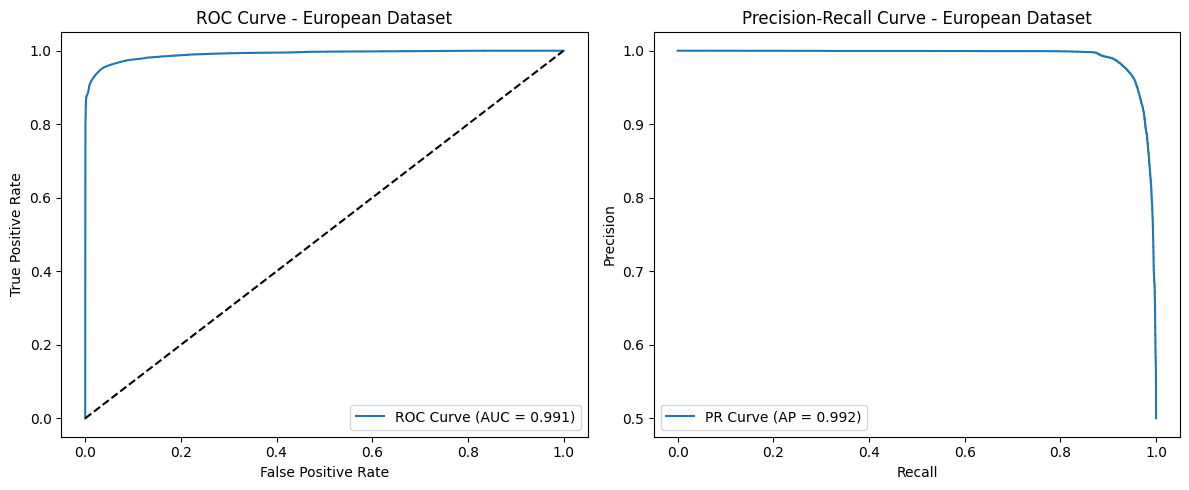

In [51]:
# ROC and PR curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, test_preds)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - European Dataset')
plt.legend()

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, test_preds)
plt.plot(recall, precision, label=f'PR Curve (AP = {test_ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - European Dataset')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
# save the model
model.save('models/european_fraud_model.h5')

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
